## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
#Imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #added
import pickle #added
from os import listdir#added
from os.path import isfile, join#added
#%matplotlib qt
%matplotlib inline


In [2]:
def save_image(dir, fname, img):
    fname = ''.join([dir,'undistorted_',fname])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(fname,img)

In [ ]:
#Undistor test images -> for create new undistord images
images = ['test1.jpg', 'test2.jpg','test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg', 'straight_lines1.jpg', 'straight_lines2.jpg']

for fname in images:
    img = cv2.imread('../test_images/'+fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    #saving to a folder
    save_image('../undistorted_images/', fname, undistorted)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [4]:
def s_filter(img,s_thresh=(170, 255)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return s_binary

In [54]:
def x_gradient_filter(img,sx_thresh=(20, 100)):
    # Sobel x
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=9) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    return sxbinary


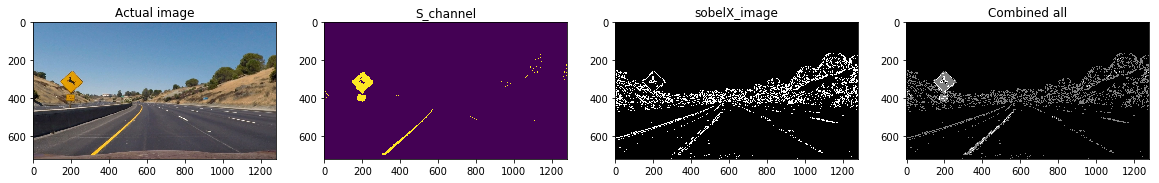

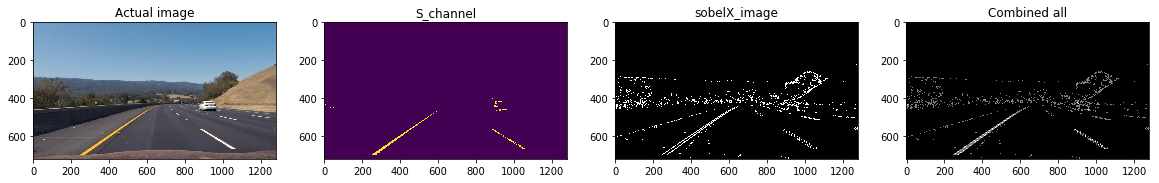

In [66]:
def process_image(image, sx_thresh, show=False):
    #HLS <- image_undist
    s_image = s_filter(image)

    #Gradient
    # Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    sobelX_image = x_gradient_filter(l_channel, sx_thresh)

    # Stack each channel
    S_sobelX_image = np.dstack(( np.zeros_like(sobelX_image), sobelX_image, s_image)) * 255
    S_sobelX_binary = sobelX_image + s_image
    #S_sobelX_binary = np.uint8(S_sobelX_binary)
    #CvType.CV_32FC2
    #print("S_sobelX_binary.shape:",S_sobelX_binary.shape)

    #image_procesed = S_sobelX_binary
    
    if show == True:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
        ax1.set_title('Actual image')
        ax1.imshow(image)
        ax2.set_title('S_channel')
        ax2.imshow(s_image)
        ax3.set_title('sobelX_image')
        ax3.imshow(sobelX_image, cmap='gray')
        ax4.set_title('Combined all')
        ax4.imshow(S_sobelX_binary, cmap='gray')
    
    return S_sobelX_binary

img = '../undistorted_images/undistorted_test2.jpg'
img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sx_thresh = (20, 80)#20,100
image_proc = process_image(img, sx_thresh, True)


img = '../undistorted_images/undistorted_test3.jpg'
img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_proc = process_image(img, sx_thresh, True)

In [9]:
def perspectiveTransform(image):
    #plt.imshow(image)
    #print(image.shape)
    image_size = (image.shape[1],image.shape[0])
    
    src = np.float32(
        [[585, 460],
        [203, 720],
        [1127, 720],
        [695, 460]])

    
    dst = np.float32(
        [[320, 0],
        [320, 720],
        [960, 720],
        [960, 0]])

    
    M = cv2.getPerspectiveTransform(src, dst)
    
    #warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    
    #plt.imshow(warped)
    return M

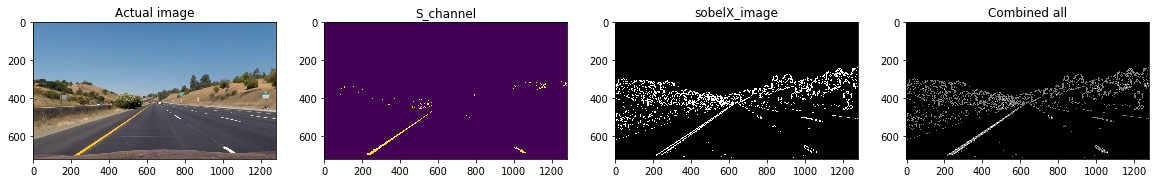

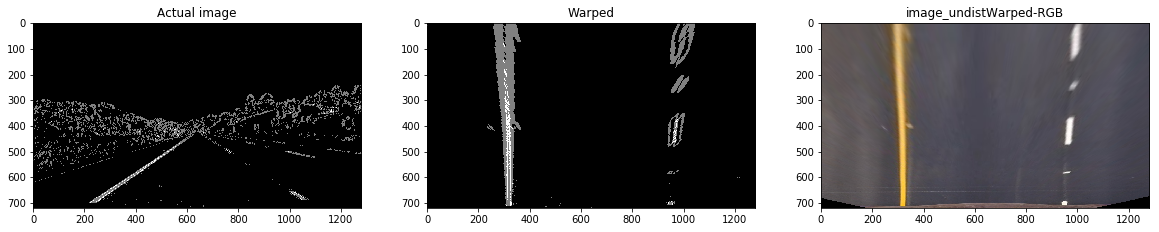

In [82]:
def warper_image(image, image_proc, M, show=False):
    #Warp
    image_size = (image_proc.shape[1],image_proc.shape[0])
    S_sobelX_binaryWarped = cv2.warpPerspective(image_proc, M, image_size, flags=cv2.INTER_LINEAR)
    #np.uint8
    
    image_size = (image.shape[1],image.shape[0])
    image_undistWarped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    
    if show == True:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.set_title('Actual image')
        ax1.imshow(image_proc, cmap='gray')
        ax2.set_title('Warped')
        ax2.imshow(S_sobelX_binaryWarped, cmap='gray')
        ax3.set_title('image_undistWarped-RGB')
        ax3.imshow(image_undistWarped)
        
    return S_sobelX_binaryWarped

img = '../undistorted_images/undistorted_straight_lines1.jpg'
img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sx_thresh = (20, 100)
image_proc = process_image(img, sx_thresh, True)

image_M = mpimg.imread('../undistorted_images/undistorted_straight_lines1.jpg')#Don´t change!
M = perspectiveTransform(image_M)

image_warper = warper_image(img, image_proc, M, True)



In [11]:
def search_corners(images_list):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for fname in images_list:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return gray,objpoints, imgpoints

In [12]:
#Calibrate function
def calibrateCamera(images):
    # Make a list of calibration images
    #images = glob.glob('../camera_cal/calibration*.jpg')
    
    #Search corners
    gray, objpoints, imgpoints = search_corners(images)
    
    #Camera calibration, given object points, image points, and the shape of the grayscale image:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    #Only the first time we need calibrate the camera
    

    return mtx, dist




True


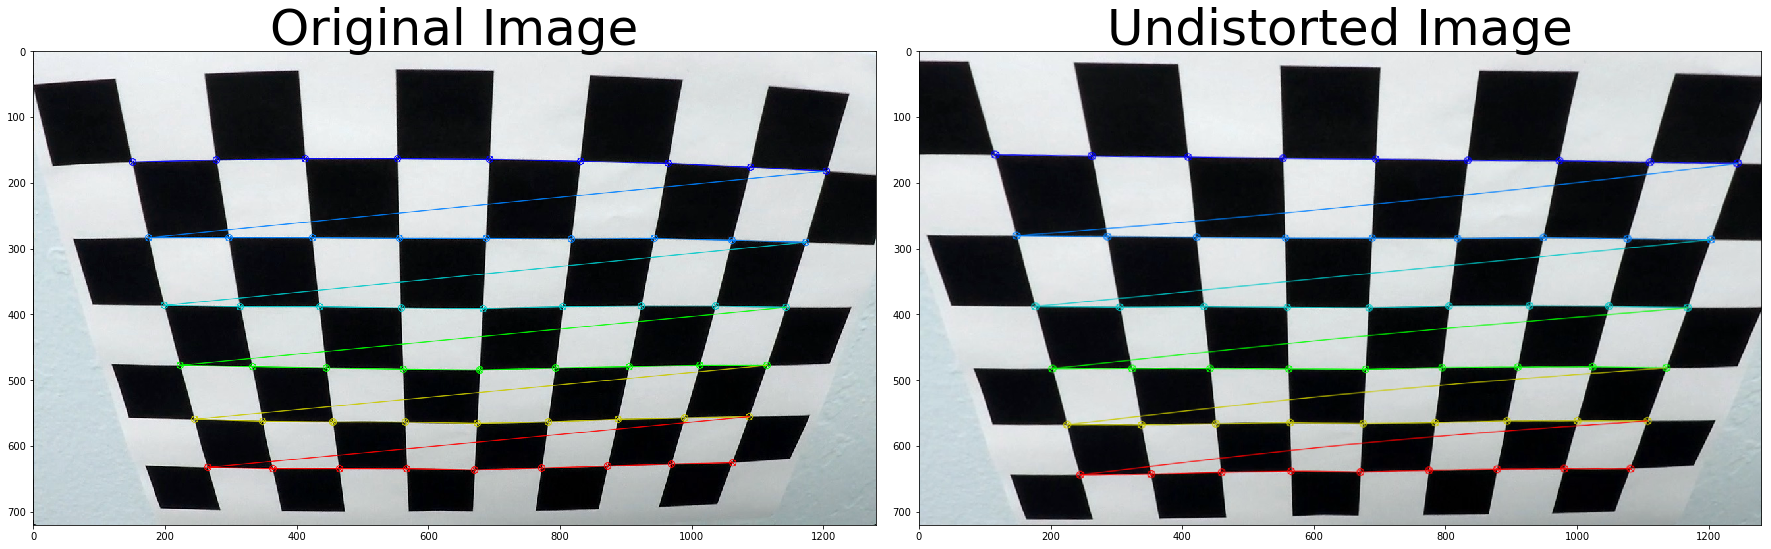

In [79]:
img = cv2.imread('../camera_cal/calibration2.jpg')
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
nx = 9
ny = 6

    # Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
print(ret)
if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)
    
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    #Save image
    save_image('../output_images/', "calibration2.jpg", undistorted)

In [13]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

In [14]:
"""
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img
"""

In [68]:
def fit_polynomial(binary_warped, nwindows = 9, margin = 50, minpix = 50):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #print("leftx:",len(leftx))
    #print("lefty:",len(lefty))

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

In [16]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [17]:
def search_around_poly(binary_warped,left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
     
    return left_fit_new, right_fit_new
    
    

In [18]:
def measure_curvature(binary_warped,left_fit,right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    #y_eval = np.max(binary_warped)
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radio of curvature
    left_curvature =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    # Calculation of R_curve (radius of curvature) -> Pixeles
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Calculation of R_curve (radius of curvature) -> meters
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    #left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    
    # Calculate vehicle center
    #left_lane and right lane bottom in pixels
    #left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    #right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    #left_lane and right lane bottomUp in pixels
    y_eval = 600
    left_lane_bottomUp = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottomUp = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    # Lane center as mid of left and right lane bottom                        
    #lane_center = (left_lane_bottom + right_lane_bottom)/2.
    lane_centerUp = (left_lane_bottomUp + right_lane_bottomUp)/2.
    
    #lane_centerUp = (right_lane_bottomUp - left_lane_bottomUp)/2
    #lane_centerUp = left_lane_bottomUp + lane_centerUp
    
    center_image = 640#1280/2
    #center = (lane_center - center_image)*xm_per_pix #Convert to meters
    #print("center:",center)
    
    centerUp = (lane_centerUp - center_image)*xm_per_pix #Convert to meters
    #print("centerUp:",centerUp)
    
    
    position = "left" if centerUp < 0 else "right"
    centerUp = "Vehicle is {:.2f}m {}".format(centerUp, position)
    
    # Now our radius of curvature is in meters
    return left_curvature, right_curvature, centerUp
    
    #return left_curverad, right_curverad

In [19]:
#Main
#Initialize----
#Calibrate camera
"""
mtx, dist = calibrateCamera() #Move to testing

#Warp
image_warp = mpimg.imread('../test_images/straight_lines1.jpg')#Don´t change!
image_warpUndist = cv2.undistort(image_warp, mtx, dist, None, mtx)
M = perspectiveTransform(image_warpUndist)
print("Initialization finished")
#End initialization----


#reading in an image
image = mpimg.imread('../test_images/straight_lines1.jpg')
print("Image loaded")
#plt.imshow(image)


#Return a image undistort
image_undist = cv2.undistort(image, mtx, dist, None, mtx)
#plt.imshow(image)

#HLS
s_image = s_filter(image_undist)

#Gradient
# Convert to HLS color space
hls = cv2.cvtColor(image_undist, cv2.COLOR_RGB2HLS)
l_channel = hls[:,:,1]
sobelX_image = x_gradient_filter(l_channel)

# Stack each channel
S_sobelX_image = np.dstack(( np.zeros_like(sobelX_image), sobelX_image, s_image)) * 255
S_sobelX_binary = sobelX_image + s_image

#Warp
image_size = (S_sobelX_binary.shape[1],S_sobelX_binary.shape[0])
S_sobelX_binaryWarped = cv2.warpPerspective(S_sobelX_binary, M, image_size, flags=cv2.INTER_LINEAR)

# Create histogram of image binary activations
histogram = hist(S_sobelX_binaryWarped)
# Visualize the resulting histogram
plt.plot(histogram)

hist_image,left_fit,right_fit = fit_polynomial(S_sobelX_binaryWarped)

# Make sure to grab the actual values from the previous step in your project!
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
#poly_image, left_fit, right_fit = search_around_poly(S_sobelX_binaryWarped,left_fit,right_fit)

#Measure curvature
left_curverad, right_curverad = measure_curvature(S_sobelX_binaryWarped,left_fit,right_fit)
print(left_curverad, right_curverad)

#S_sobelX_binaryWarped = np.dstack((S_sobelX_binaryWarped, S_sobelX_binaryWarped, S_sobelX_binaryWarped))*255
#image_ev_data = hist_image + left_fitx

#Visualization
f, axarr = plt.subplots(7,1, figsize=(60,60))
axarr[0].imshow(image)
axarr[1].imshow(image_undist)
axarr[2].imshow(s_image)
axarr[3].imshow(sobelX_image)
axarr[4].imshow(S_sobelX_image)
axarr[5].imshow(S_sobelX_binaryWarped)
axarr[6].imshow(hist_image)
#axarr[7].imshow(poly_image)
#axarr[7].imshow(image_ev_data)
"""


'\nmtx, dist = calibrateCamera() #Move to testing\n\n#Warp\nimage_warp = mpimg.imread(\'../test_images/straight_lines1.jpg\')#Don´t change!\nimage_warpUndist = cv2.undistort(image_warp, mtx, dist, None, mtx)\nM = perspectiveTransform(image_warpUndist)\nprint("Initialization finished")\n#End initialization----\n\n\n#reading in an image\nimage = mpimg.imread(\'../test_images/straight_lines1.jpg\')\nprint("Image loaded")\n#plt.imshow(image)\n\n\n#Return a image undistort\nimage_undist = cv2.undistort(image, mtx, dist, None, mtx)\n#plt.imshow(image)\n\n#HLS\ns_image = s_filter(image_undist)\n\n#Gradient\n# Convert to HLS color space\nhls = cv2.cvtColor(image_undist, cv2.COLOR_RGB2HLS)\nl_channel = hls[:,:,1]\nsobelX_image = x_gradient_filter(l_channel)\n\n# Stack each channel\nS_sobelX_image = np.dstack(( np.zeros_like(sobelX_image), sobelX_image, s_image)) * 255\nS_sobelX_binary = sobelX_image + s_image\n\n#Warp\nimage_size = (S_sobelX_binary.shape[1],S_sobelX_binary.shape[0])\nS_sobelX_b

In [20]:
def draw_on_image(undist, warped_img, left_fit, right_fit, M, left_curvature, right_curvature, center, show_values = False):
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    #warp_zero = np.zeros_like(warped_img)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #cv2.fillPoly(warped_img, np.int32([pts]), (255,0, 0))#Red
    
    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    #newwarp = cv2.warpPerspective(warped_img, Minv, (undist.shape[1], undist.shape[0]), flags=cv2.INTER_LINEAR)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
     
    cv2.putText(result, 'Left curv.: {:.0f} m'.format(left_curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Right curv.: {:.0f} m'.format(right_curvature), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, '{}'.format(center), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    if show_values == True:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(result)
        
    return result 

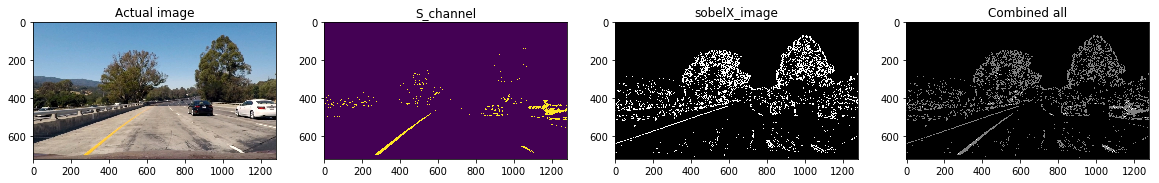

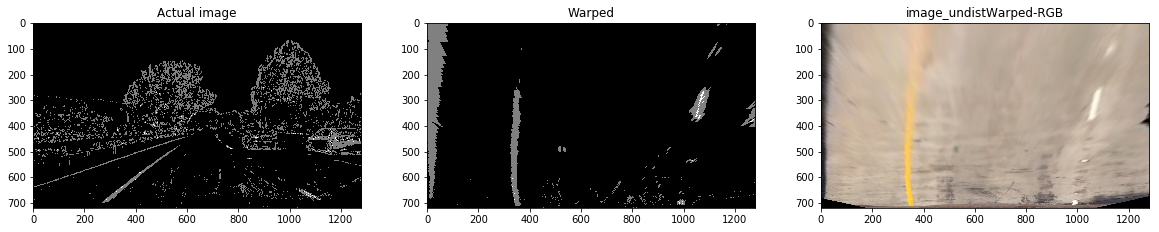

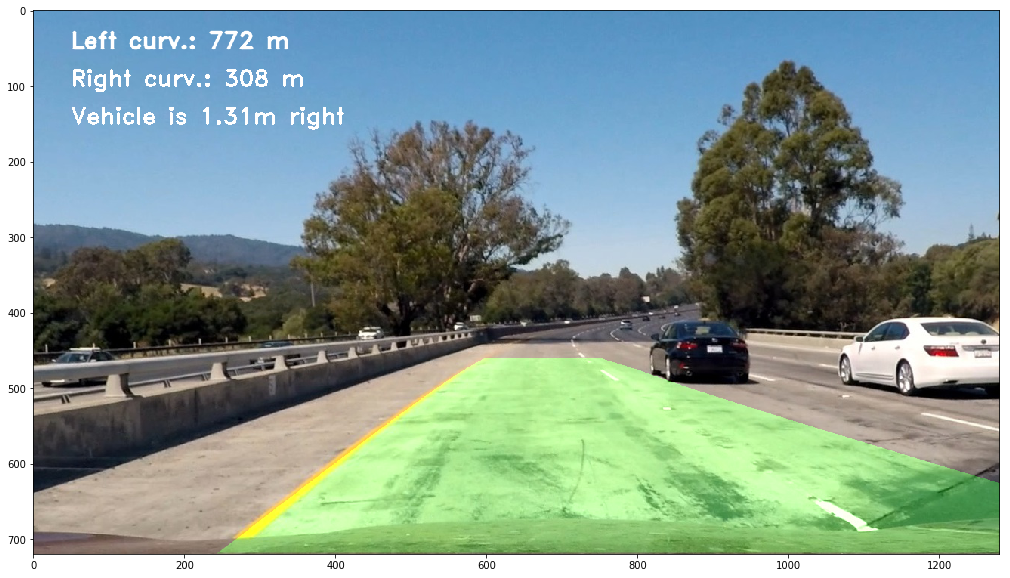

In [80]:
#test
img = '../undistorted_images/undistorted_test1.jpg'
img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sx_thresh = (20, 100)
image_proc = process_image(img, sx_thresh, True)

image_M = mpimg.imread('../undistorted_images/undistorted_straight_lines1.jpg')#Don´t change!
M = perspectiveTransform(image_M)

image_warper = warper_image(img, image_proc, M, True)
#--

left_fit, right_fit = fit_polynomial(image_warper)

left_curvature, right_curvature, center = measure_curvature(image_warper,left_fit,right_fit)

res = draw_on_image(img, image_warper, left_fit, right_fit, M, left_curvature, right_curvature, center, True)


In [22]:
def is_lane_valid(left_fit, right_fit):
    
    #Check if left and right fit returned a value
    #print("len(left_fit):",len(left_fit))
    #print("len(right_fit):",len(right_fit))
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False

    else:
        #Check distance b/w lines
        ploty = np.linspace(0, 20, num=10 )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        delta_lines = np.mean(right_fitx - left_fitx)
        
        #print("delta_lines:",delta_lines)
        if delta_lines >= 150 and delta_lines <=430: 
            status = True
        else:
            status = False
        
        # Calculate slope of left and right lanes at midpoint of y (i.e. 360)
        left = 2*left_fit[0]*360+left_fit[1]
        right = 2*right_fit[0]*360+right_fit[1]
        delta_slope_mid =  np.abs(left-right)
        
        #Check if lines are parallel at the middle
        #print("delta_slope_mid:",delta_slope_mid)
        if delta_slope_mid <= 0.1:
            status = True
        else:
            status = False
            
    return status

In [23]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #Counter
        self.counter = 0
        self.last_left = None
        self.last_right = None
        self.left_fit = None
        self.right_fit = None
        self.reset_counter = 0
        self.initialized = False
        self.mtx = None
        self.dist = None
        self.M = None
        self.left_curverad = None
        self.right_curverad = None
        self.center = None
                
line = Line()

In [25]:
def resetLine():
    line.counter = 0
    line.last_left = None
    line.last_right = None
    line.left_fit = None
    line.right_fit = None
    line.reset_counter = 0
    line.initialized = False
    line.mtx = None
    line.dist = None
    line.M = None
    line.left_curverad = None
    line.right_curverad = None
    line.center = None

In [24]:
def findingLines(image):
    #Initialize----
    if line.initialized == False:
        line.initialized = True
        #Calibrate camera
        images_calibrate = glob.glob('../camera_cal/calibration*.jpg')
        line.mtx, line.dist = calibrateCamera(images_calibrate)

        #M
        image_M = mpimg.imread('../undistorted_images/undistorted_straight_lines1.jpg')#Don´t change!
        line.M = perspectiveTransform(image_M)
        
    #End initialization----

    #Process image:
    #1st undistor image
    image = cv2.undistort(image, line.mtx, line.dist, None, line.mtx)
    
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sx_thresh = (20, 100)
    image_proc = process_image(image, sx_thresh, False)
    #image_proc = combined_s_gradient_thresholds(image, False)

    
    #Warp image:
    image_warper = warper_image(image, image_proc, line.M, False)
    
    #Calculate points line and poly:
    if line.counter == 0:
        line.left_fit, line.right_fit = fit_polynomial(image_warper)
    else:
        line.left_fit, line.right_fit  = search_around_poly(image_warper, line.left_fit, line.right_fit)


    #For videos caution!!
    status = is_lane_valid(line.left_fit, line.right_fit)
    
    if status == True:        
        line.last_left, line.last_right = line.left_fit, line.right_fit        
        line.counter += 1
        line.reset_counter = 0
    else:   
        #Reset
        if line.reset_counter > 4:
            line.left_fit, line.right_fit = fit_polynomial(image_warper)
            line.reset_counter = 0
        else:
            if line.counter > 0:
                line.left_fit, line.right_fit = line.last_left, line.last_right
            
        line.reset_counter += 1
        
    #print("line.counter:",line.counter)
    #print("line.reset_counter:",line.reset_counter)
    return image_warper, line.left_fit, line.right_fit, line.M


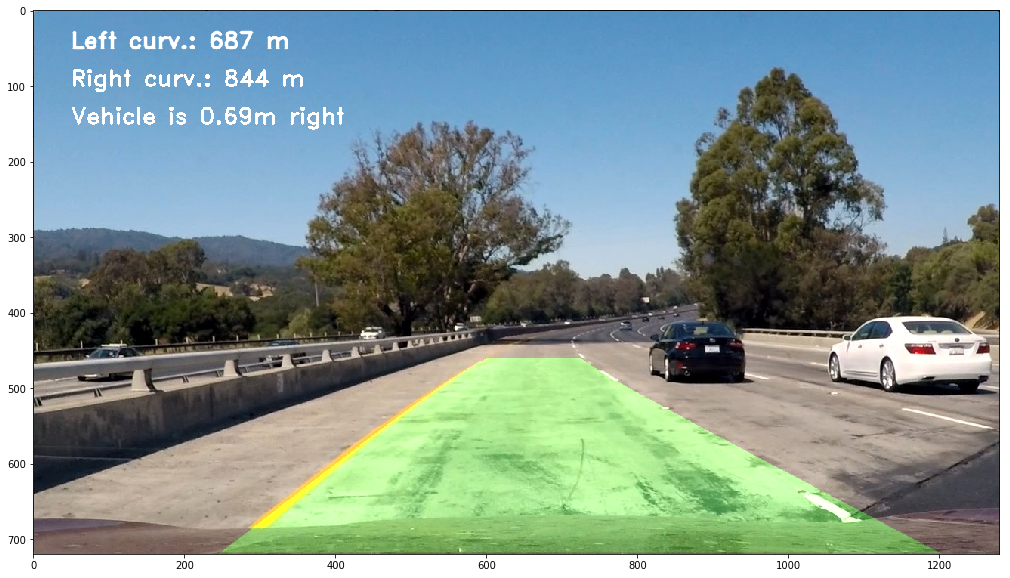

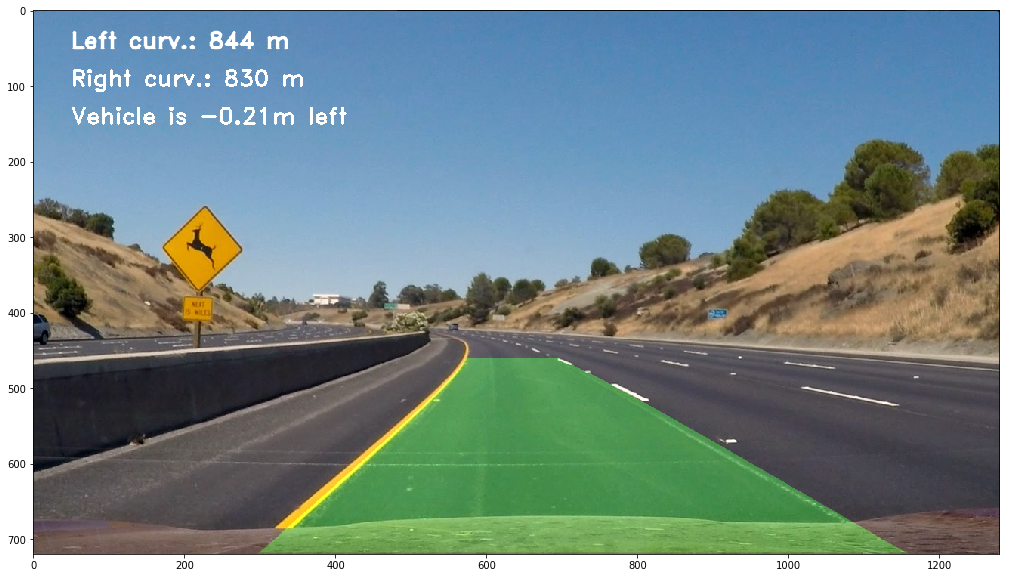

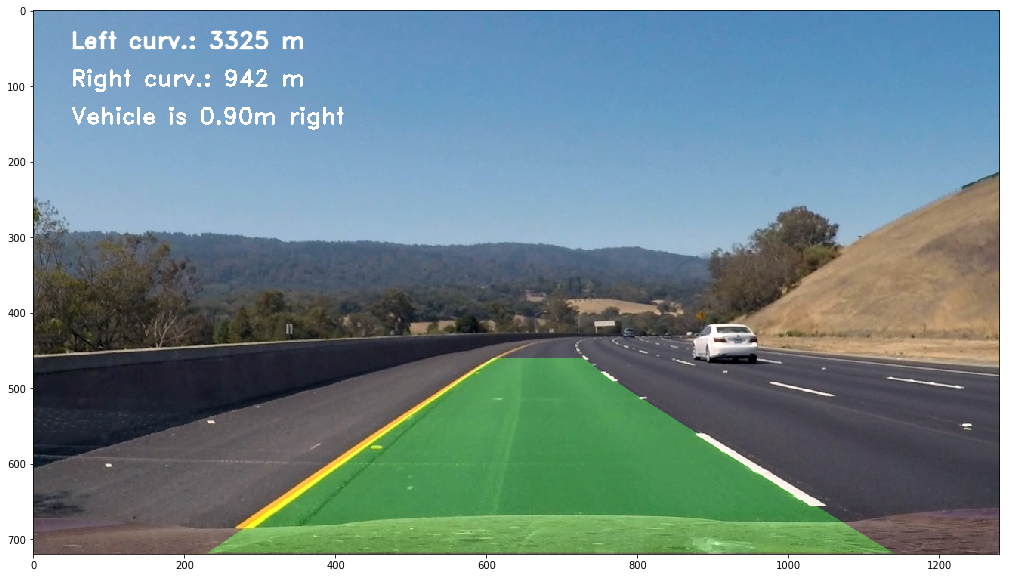

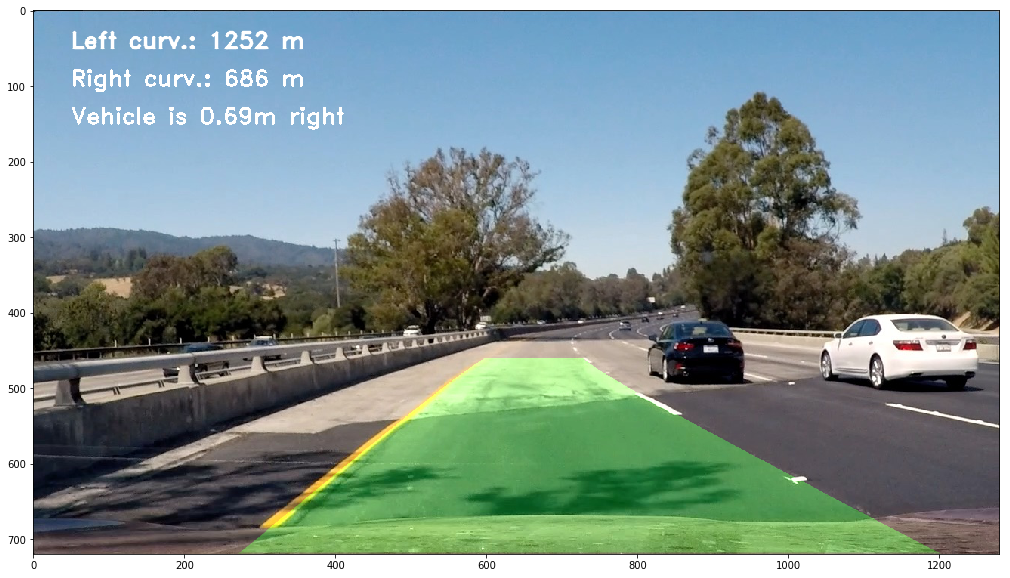

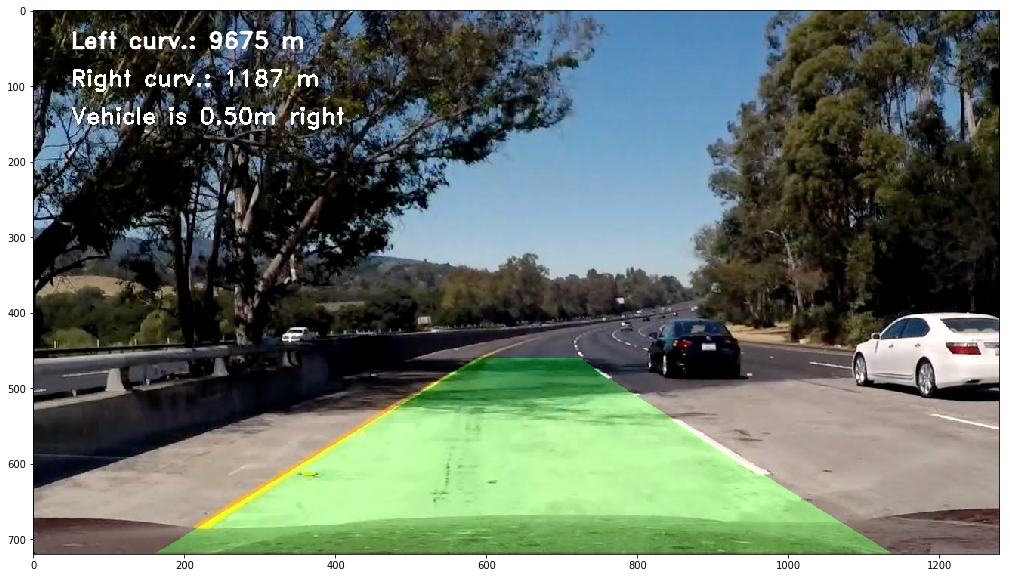

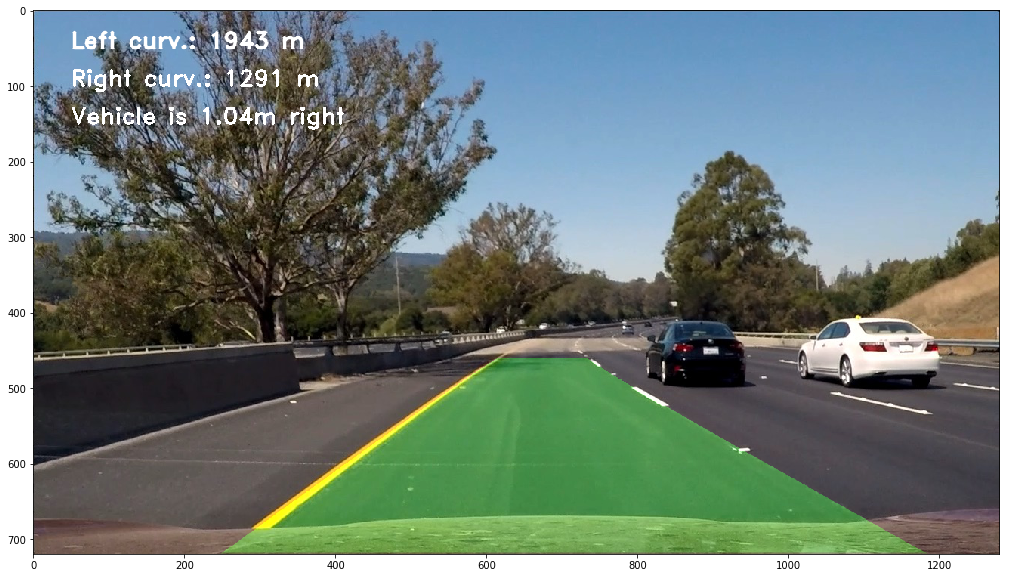

In [72]:
def pipeline(image, show_values=False, video=False):
    
    if video == False:
        resetLine()
    #Process and calculate points line and poly:
    image_warper, left_fit, right_fit, M = findingLines(image)
    
    #Calculate curvature
    left_curvature, right_curvature, center = measure_curvature(image_warper,left_fit,right_fit)

    #Visualize?
    draw_out = draw_on_image(image, image_warper, left_fit, right_fit, M, left_curvature, right_curvature, center, show_values)
    
    return draw_out

#Test
resetLine()
images = ['test1.jpg', 'test2.jpg','test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']
for fname in images:
    #resetLine()
    image = cv2.imread('../test_images/'+fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    out = pipeline(image, True, False)
    
    #Save image
    save_image('../output_images/', fname, out)   
    


In [29]:
resetLine()

VIDEO

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [74]:
line = Line()
def process_frame(img):
    return pipeline(img,False,True)

video_output = '../output_video/harder_challenge_video_all.mp4'
#clip1 = VideoFileClip("../project_video.mp4").subclip(0,3)
clip1 = VideoFileClip("../harder_challenge_video.mp4")


white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ../output_video/harder_challenge_video_all.mp4
[MoviePy] Writing video ../output_video/harder_challenge_video_all.mp4


100%|█████████▉| 1199/1200 [04:41<00:00,  4.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_video/harder_challenge_video_all.mp4 

CPU times: user 2min 14s, sys: 2.52 s, total: 2min 17s
Wall time: 4min 45s
